<a href="https://colab.research.google.com/github/Manuel-FA/Deep_Learning/blob/main/Car%20Object%20Detection%20-%20Dataset_1%20-%20Beginner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="#000080B">**ABSTRACT**</font>

*   RESUMEN
*   Model:
*   Libraries used: Numpy, Pandas, MatPlotLib, Seaborn, Scikitplot and Sklearn

# <font color="#000080B">**1. Introduction**</font>
---


## <font color="#000080B">**1.1. Content**</font>


    1. Introduction
      1.1. Content
      1.2. Problem statement
    2. Project preparation
      2.1. Libraries import
      2.2. Data import
    3. Exploratory data analysis
      3.1. Data information
      3.2. Categorical variables
      3.3. Univariate analysis
      3.4. Bivariate analysis
    4. Data prepprocessing
      4.1. Removing redundat variables
      4.2. Removing outliers
      4.3. Filling missing values
      4.4. Encoding categorical features
    5. Modeling
      5.1. Dataset preparation
      5.2. Training and validation
    6. Interpretation of results
      6.1. Model evaluation
      6.2. ROC curve
      6.3. Important features


## <font color="#000080B">**1.2. Problem statement**</font>

CONTEXTO DEL PROBLEMA A RESOLVER

## <font color="#000080B">**2.1. Libraries import**</font>

In [20]:
# data import
from google.colab import drive

# data manipulation
import numpy as np
import pandas as pd

# visualization/image processing
import matplotlib.pyplot as plt
import cv2

# machine learning
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

# Other
#es un módulo en la biblioteca estándar de Python que proporciona una forma más intuitiva y robusta de trabajar con rutas de
#archivos y directorios en comparación con métodos más antiguos como os.path
#La clase Path representa rutas de archivos y directorios como objetos que se pueden manipular
#fácilmente y utilizar para diversas operaciones de archivo.
from pathlib import Path

## <font color="#000080B">**2.2. Data import**</font>

In [21]:
drive.mount('/content/drive')
train_path = Path("/content/drive/MyDrive/Datasets/training_images")
test_path = Path("/content/drive/MyDrive/Datasets/testing_images")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
train_bounding_boxes = pd.read_csv("/content/drive/MyDrive/Datasets/train_solution_bounding_boxes.csv")

# <font color="#000080B">**3. Exploratory data analysis**</font>
---


In [23]:
train_bounding_boxes.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422

Since `cv2`, the library we'll be using to plot the bounding boxes and the images, only accepts integer values as vertices, we'll need to convert the coordinates of the bounding boxes to integers.

The dataset contains information about multi-object detection; however, this notebook is concerned with single object detection. To account for this slight discrepancy, we will omit the duplicate values of the `image` column. This results in each image having only one corresponding set of bounding box coordinates.

In [7]:
train_bounding_boxes[['xmin', 'ymin', 'xmax', 'ymax']] = train_bounding_boxes[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train_bounding_boxes.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Next, I'll create some utility functions that make it easy to display images from files and dataframes.

In [8]:
# No tiene sentido tener este código en forma de función en la mayoría de los casos, en la parte de optimización se debe arreglar esto
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    # if the image has been normalized, scale it up
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # Draw the bounding boxes
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        # cv2.rectangle se utiliza para dibujar rectángulos en imágenes. Sus argumentos son: Imagen de destino (img), Coordenadas del vértice superior izquierdo (pt1),
        # Coordenadas del vértice inferior derecho (pt2), Color del rectángulo (color) y Grosor del borde (thickness).
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    # cv.imread se utiliza para cargar imágenes (desde archivos) en forma de matrices NumPy
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

# al parcer esta es redundante ya qye solo se utiliza una vez
def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)

# esta también solo se utiliza una vez
def display_grid(df=train_bounding_boxes, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])


**A quick formatting note**: the green rectangle represents the correct bounding whereas the red rectangle represents the predicted bounding box. This convention is used throughout this notebook.

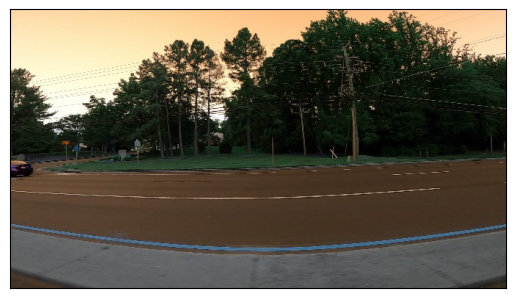

In [9]:
display_image_from_file("vid_4_10520.jpg")

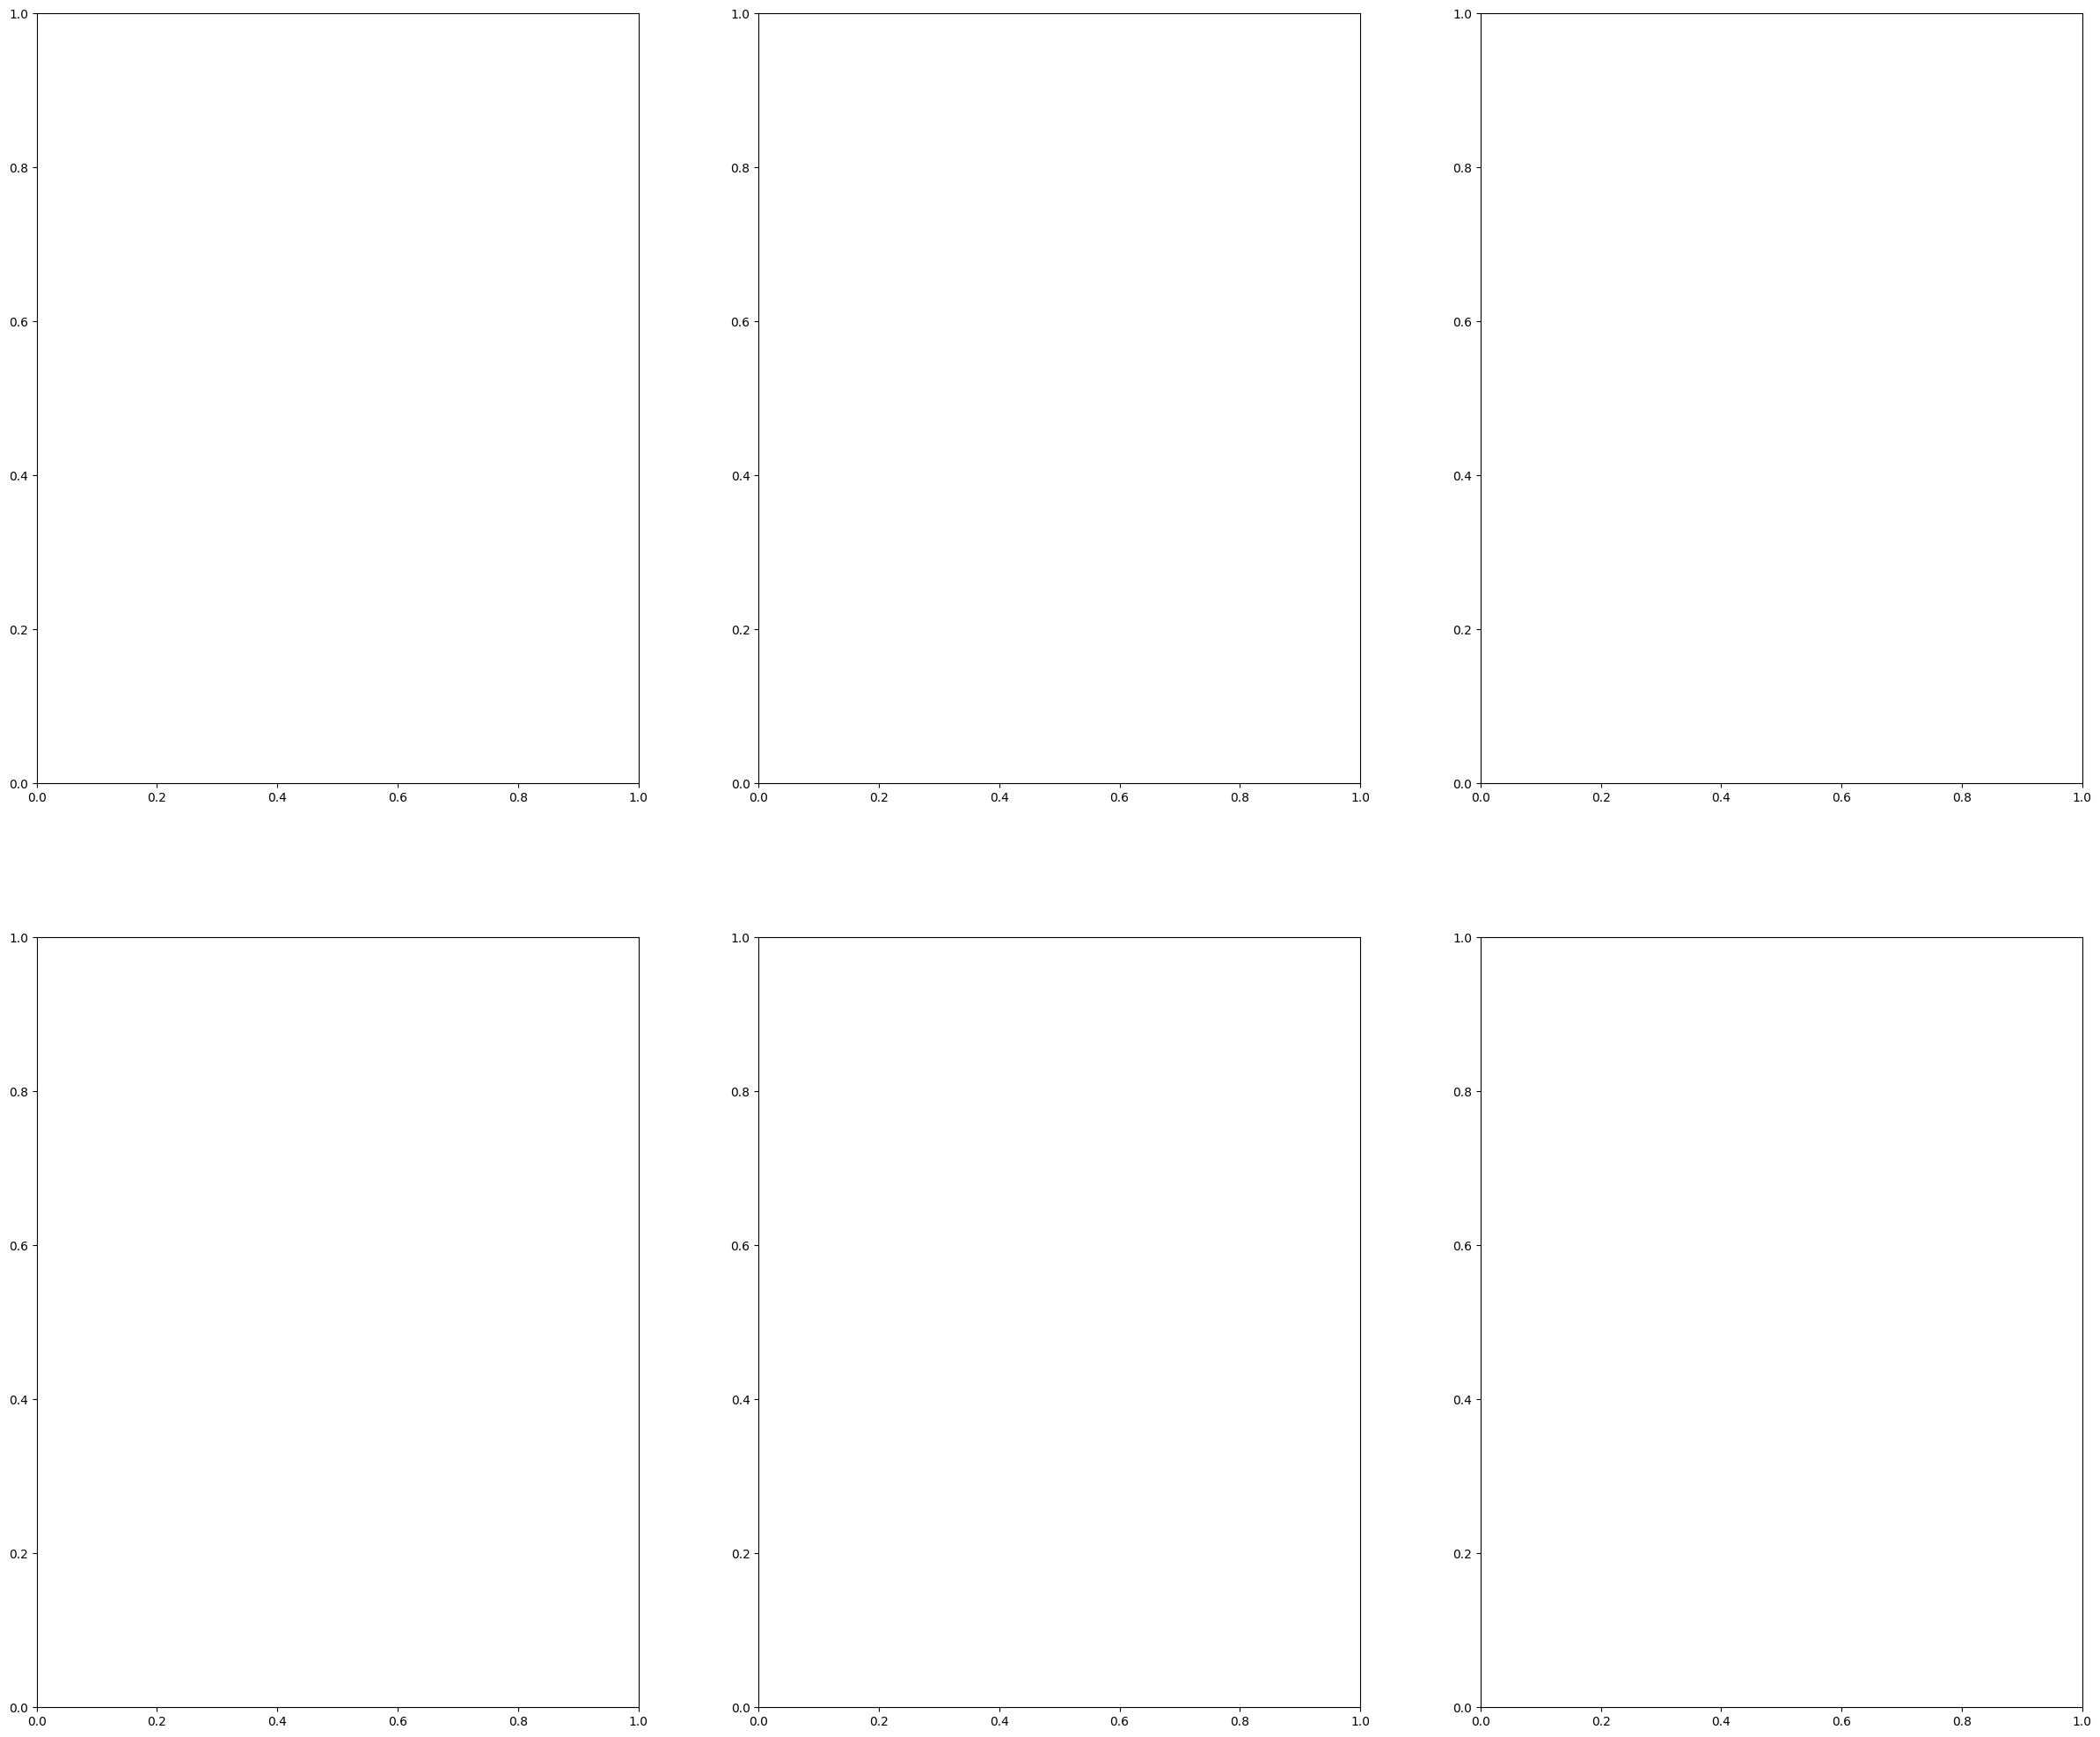

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 25))
axs = axs.ravel()

# for name in train_bounding_boxes["image"]
#   img = cv2.imread(str(train_path/name))
#   plt.imshow(img)

In [18]:
from google.colab.patches import cv2_imshow

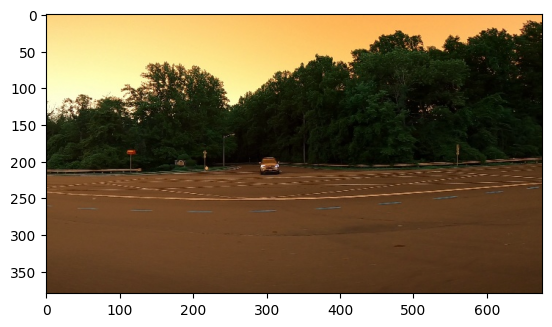

In [27]:
name = 'vid_4_1000.jpg'
img = cv2.imread(str(train_path/name))
plt.imshow(img)

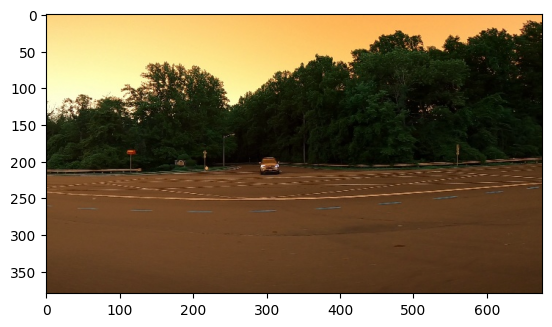

In [30]:
# Supongamos que tienes una lista de rutas de archivo de imágenes en 'image_paths'
image_paths = ['vid_4_1000.jpg', 'vid_4_10000.jpg', 'vid_4_10040.jpg', '	vid_4_10020.jpg	', 'vid_4_10060.jpg']

for image_path in image_paths:
    # Lee la imagen utilizando cv2
    image = cv2.imread(str(train_path/name))
    plt.imshow(image)


#   img = cv2.imread(str(train_path/name))
#   plt.imshow(img)

ESTA ES LA FORMA CORRECTA, AHORA HAY QUE HACERLO PARA QUE LO HAGA DE FORMA ALAEATORIA PARA QUE UNA MUESTRA MEJOR

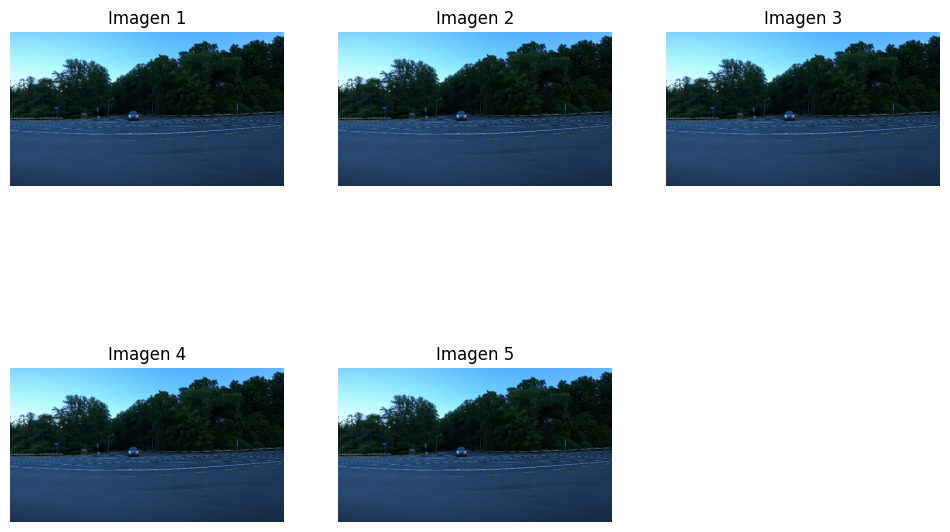

In [32]:
# Supongamos que tienes una lista de rutas de archivo de imágenes en 'image_paths'
image_paths = ['vid_4_1000.jpg', 'vid_4_10000.jpg', 'vid_4_10040.jpg', 'vid_4_10020.jpg', 'vid_4_10060.jpg']

# Crea una figura de Matplotlib para mostrar las imágenes en una ventana
fig = plt.figure(figsize=(12, 8))

for i, image_path in enumerate(image_paths):
    # Lee la imagen utilizando cv2
    image = cv2.imread(str(train_path/name))

    # Define subtramas para mostrar las imágenes en una cuadrícula
    plt.subplot(2, 3, i + 1)  # Cambia los números para ajustar la cuadrícula

    # Muestra la imagen en la subtrama actual
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Imagen {i+1}')
    plt.axis('off')  # Desactiva los ejes

# Actualiza la ventana de visualización
plt.show()

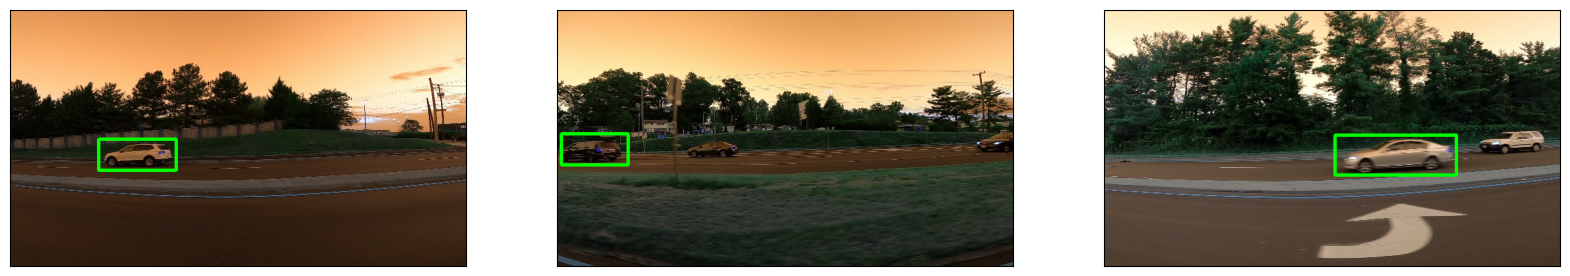

In [10]:
display_grid()

The functions work perfectly, and the logic for the bounding boxes seems to be flawless. We can now move on to creating and training the model.

# Model Training Todavía no se está entretando nada

## Data Generator

Before training the model, we must define a generator that keras accepts. If you're not familiar with python generators or are in need of a quick refresher, check out [this resource](https://www.programiz.com/python-programming/generator).

In keras, all we need to do is initialize some arrays containing images and their corresponding bounding box coordinates. Then, we simply return the newly-created arrays in a dictionary.

# <font color="#000080B">**4. Data preprocessing**</font>
---


In [ ]:
# esta función serive para organizar la información de la imagen desde la carpeta de imagenes con la información del dataframe de las
# cajas delimitadoras
def data_generator(df=train_bounding_boxes, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
                rand_index = np.random.randint(0, train_bounding_boxes.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}


The dictionary keys are crucial, as keras needs them to locate the correct input/output.

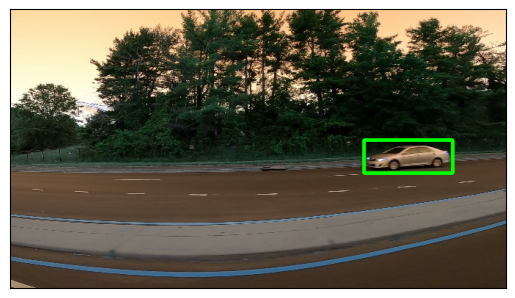

In [ ]:
#En esta sección se aplica la funcion de data_generator para vizulizar la imagen con su respectiva caja delimitadora
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

# <font color="#000080B">**5. Modeling**</font>

---

I'll use keras' functional API as it's incredibly easy to utilize custom inputs and predict custom outputs. Specifically, I'll use a fairly large neural network to start out with, and adjust the parameters of the layers if necessary.

Notice that the dictionary keys in the generator correspond to the names of the input and output layers.

In [ ]:
# Aquí, se define la entrada del modelo. El modelo espera imágenes de forma (380, 676, 3),
# que corresponde a imágenes en color con un tamaño de 380 píxeles de alto, 676 píxeles de ancho
#y 3 canales de color (rojo, verde y azul).
input_ = Input(shape=[380, 676, 3], name='image')

# Se inicia una variable x que se utilizará para construir la arquitectura de la red neuronal.
# esta información se gaurdará en la variable "output"
x = input_

# se realiza un conjunto de capas de convolución, normalización y agrupación. En cada iteración se duplica el numero de
# filtros para aumentar gradualmetne la capacidad de la red neuronal
for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

# Después de las capas convolucionales, se aplana la salida utilizando Flatten. Luego, se agregan
# dos capas completamente conectadas (Dense) con activaciones ReLU. La última capa tiene 4 neuronas,
# lo que sugiere que se espera que el modelo produzca 4 valores como salida (posiblemente coordenadas de cajas delimitadoras).
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

#Se realizó una extensa investigación, que en la face de

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 16)      64    

100 million parameters! I suppose that's fine for now; although, if I consider exporting this model, I will be left with a very very large file.

Moving on, we'll compile the model.

For each output, we need to specify a loss and a metric. To do this, we simply reference the dictionary key used in the generator and assign it our desired loss function/metric.

## <font color="#000080B">**6.2. Model Building**</font>

In [ ]:
# se ajusta las caracteristicas d ela compilación, la métrica qeu se utiliza para valuar es el de error cuadrático medio
model.compile(
    loss={
        'coords': 'mse'
    },
# se utiliza el optimziador Adam, uno muy utilizado
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

Before we actually train the model, let's define a callback that tests the current model on three, randomly selected images.

In [ ]:
# Some functions to test the model. These will be called every epoch to display the current performance of the model
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]

    img = X[0]
    gt_coords = y[0]

    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

We'll quickly use these methods to evaluate the current performance of our model.

1/1 [==============================] - 0s 36ms/step


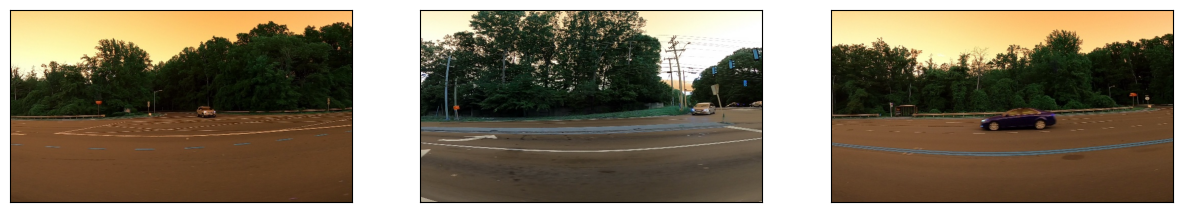

In [ ]:
test(model)

## <font color="#000080B">**5.3. Training and validation**</font>

The model isn't great; in fact, its predictions aren't even visible.

But, the model's poor performance is expected as we haven't even trained the model yet.
So, let's do just that.

We'll use Kaggle's GPU to train the model in order to drastically speed up the training process.

Epoch 1/9
  6/500 [..............................] - ETA: 1:48 - loss: 60735.9688 - accuracy: 0.4792

1/1 [==============================] - 0s 75ms/step


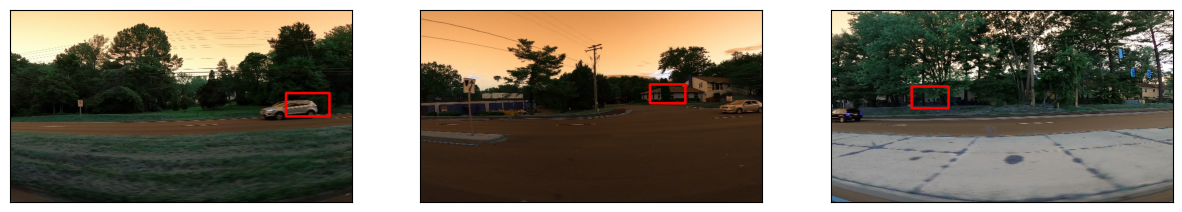

500/500 [==============================] - 168s 305ms/step - loss: 4417.0801 - accuracy: 0.8813
Epoch 2/9
1/1 [==============================] - 0s 33ms/step


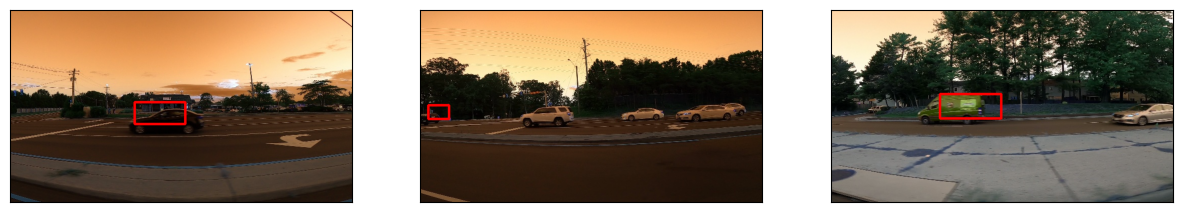

500/500 [==============================] - 159s 319ms/step - loss: 758.9498 - accuracy: 0.9669
Epoch 3/9
1/1 [==============================] - 0s 36ms/step


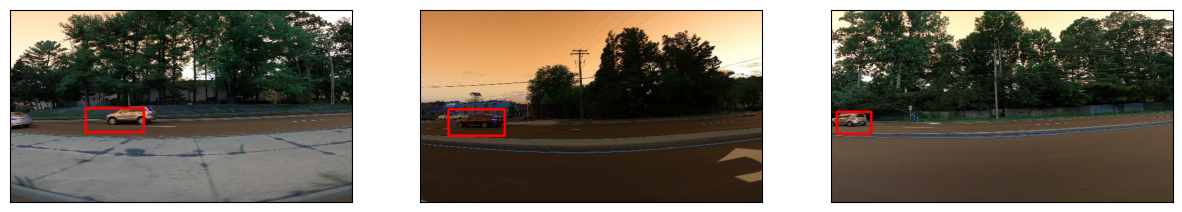

500/500 [==============================] - 152s 305ms/step - loss: 951.5228 - accuracy: 0.9589
Epoch 4/9
1/1 [==============================] - 0s 31ms/step


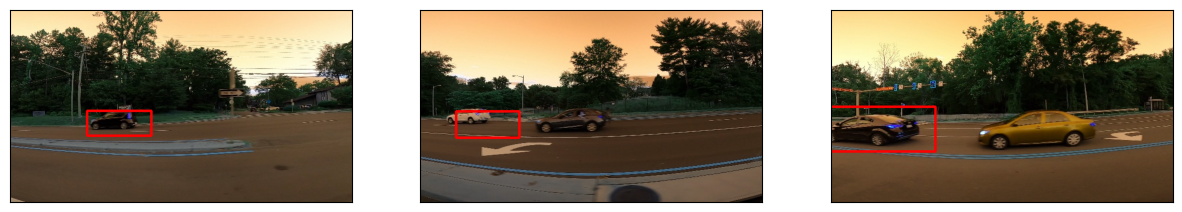

500/500 [==============================] - 153s 306ms/step - loss: 240.0736 - accuracy: 0.9819
Epoch 5/9
1/1 [==============================] - 0s 37ms/step


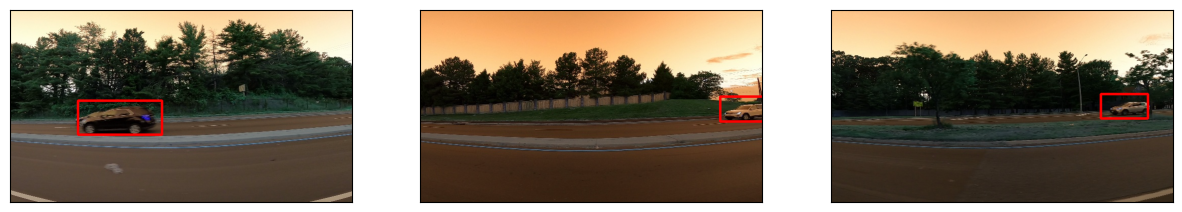

500/500 [==============================] - 155s 310ms/step - loss: 160.6523 - accuracy: 0.9858
Epoch 6/9
1/1 [==============================] - 0s 39ms/step


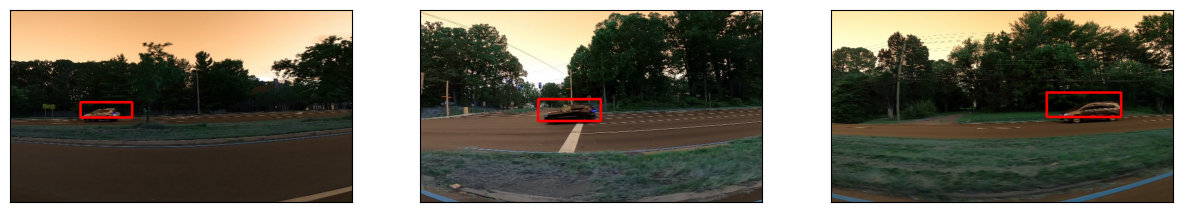

500/500 [==============================] - 155s 310ms/step - loss: 121.7102 - accuracy: 0.9884
Epoch 7/9
1/1 [==============================] - 0s 34ms/step


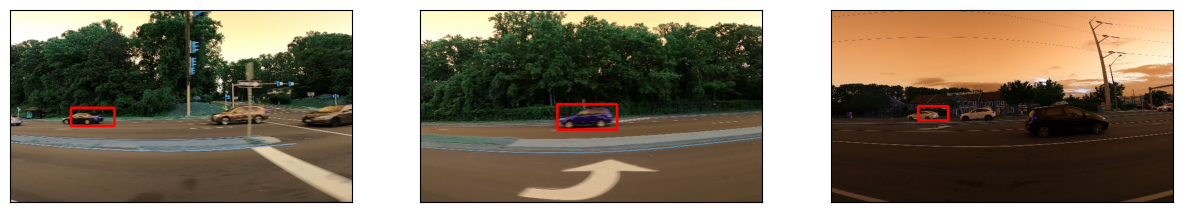

500/500 [==============================] - 156s 312ms/step - loss: 110.9389 - accuracy: 0.9912
Epoch 8/9
1/1 [==============================] - 0s 48ms/step


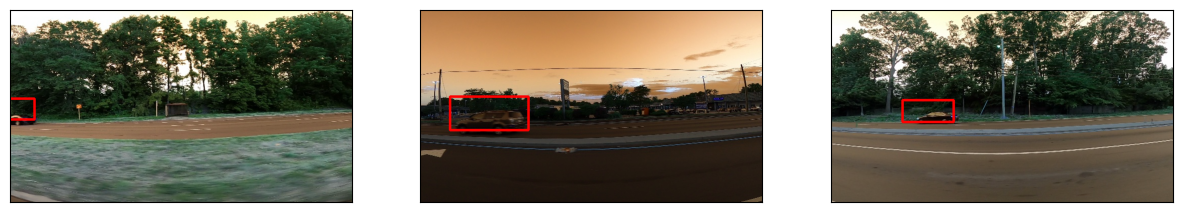

500/500 [==============================] - 156s 311ms/step - loss: 93.1947 - accuracy: 0.9881
Epoch 9/9
1/1 [==============================] - 0s 58ms/step


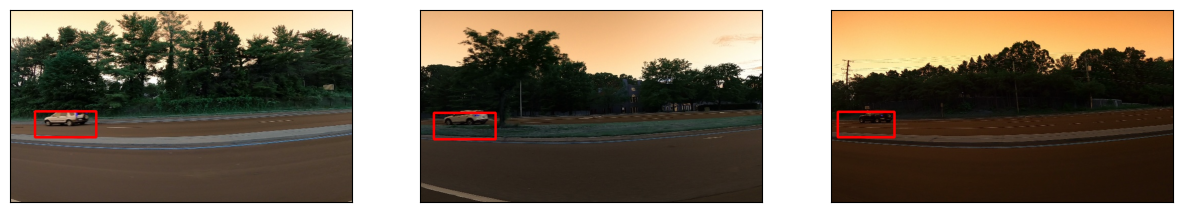

500/500 [==============================] - 158s 316ms/step - loss: 640.0560 - accuracy: 0.9711


In [ ]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=500,
        callbacks=[
            ShowTestImages(),
        ]
    )

The model is doing quite well; the `MSE` is relatively low and the accuracy is very high.

Since the model training seems to be complete, we can now export the model and store it for later use.

In [ ]:
model.save('car-object-detection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Conclusion
This notebook described the setup of a single object detection model, along with the training process. Moreover, this notebook provided some insight on how to deal with datasets that aren't necessarily in a format compatible with the default keras settings. Lastly, this notebook described the thinking that goes behind approaching a computer vision problem such as single object detection.

For those eager to dive deeper, here are some more computer vision projects:
 - Image Segmentation
 - Single Object Detection (with videos)
 - Multiple Object Detection (with images)
 - Multiple Object Detection (with videos)
 - Object Detection and Classification (with images and videos)

If you found this notebook helpful, consider upvoting. Upvotes allow this notebook to circulate around Kaggle, thus resulting in the notebook reaching and helping more people.

### Thanks for Reading!